# Projeto Airbnb - Previsão de Preço de Imóveis

### Contexto

O Airbnb é um aplicativo utilizado para o aluguel de imoveis de vários tipos por diária.

Para disponibilizar seus imóveis, os hosts devem descrever suas caracteristicas com o máximo de detalhes possível, de forma que ajude os locadores a escolherem o local que melhor atende suas necessidades.

Algumas das características de um imóvel são: preço, quantidade de camas, quartos, tipo de quarto, tipo de cama etc.

### Objetivo

Criar um modelo de previsão do preço de cada imóvel baseado em suas características. Permitindo que um host ou locador saiba qual o preço adequado para cada local.

### Créditos e Referências

Base de dados: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Este projeto foi elaborado sob a orienteção do curso Python Impressionador, da Hashtag Treinamentos. <br>
Professor: João Lira

A solução original foi elaborada por Allan Bruno e publicada no Kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb


- As bases de dados são de abril/2018 a maio/2020
- Os dados são do Rio de Janeiro

### Importar Bibliotecas



In [ ]:
#importar conexao entre google collab e Drive
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files

import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
import joblib

### Importar e Consolidar Base de Dados

In [ ]:
#criar dicionario para pegar numero do mes de acordo com o nome do arquivo
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

#pathlib captura todo o caminho a té a pasta 'dataset' (onde estão todos os arqvs csv) e guarda na variavel
caminho_bases = pathlib.Path(r'/content/drive/MyDrive/Hashtag-Python/Projeto 3 - Ciência de Dados - Aplicação de Mercado de Trabalho/Dataset')

#criar um dataframe vazio
base_airbnb = pd.DataFrame()

#itera sobre cada arquivo dentro do diretorio 'dataset'
for arquivo in caminho_bases.iterdir():

    #pega os caracteres de 0 a 2 do nome do arquivo csv e armazena na variavel
    nome_mes = arquivo.name[:3]
    #associa os 3 caracteres ao numero do mes correspondente no dicionario
    mes = meses[nome_mes]

    #pega o final do nome do arquivo
    ano = arquivo.name[-8:]
    #transforma o final do nome em numero inteiro
    #substitui o .csv por nada pra ficar só o ano
    ano = int(ano.replace('.csv', ''))

    #concatena caminho em 'caminho_bases' com o nome do arquivo iterado
    #em seguida usa pd.read para armazenar o arquivo na variavel df como dataframe
    df = pd.read_csv(caminho_bases / arquivo.name)

    #adiciona colunas mes e ano de acordo com o valor das variaveis
    df['ano'] = ano
    df['mes'] = mes

    #pega o dataframe que está em df e faz append no dataframe base_airbnb
    base_airbnb = base_airbnb.append(df)

display(base_airbnb)    

### Excluir colunas inuteis

In [ ]:
#exportar o dataframe para vizualizar no excel
base_airbnb.head(1000).to_csv('Head_base_airbnb.csv', sep = ';')

### Colunas que ficam:

In [ ]:
#criar uma lista com os nomes das colunas
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']

#filtrar o dataframe com apenas as colunas da lista
base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)


### Tratar Valores Faltando

In [ ]:
# ver valores vazios no df
print(base_airbnb.isnull().sum())

# ou ver resumo dos dados de cada coluna

#base_airbnb.info()

#### Decisões

- Excluir colunas com mais de 300 mil valores null
  - neste caso, não será possivel preencher os valores com estimativas
- Nas colunas restantes, excluir as linhas que contém dados null

In [ ]:
# remover colunas
for coluna in base_airbnb:
  if base_airbnb[coluna].isnull().sum() > 300000:
    base_airbnb = base_airbnb.drop(coluna, axis = 1)

# remover linhas
base_airbnb = base_airbnb.dropna()

print(base_airbnb.isnull().sum())

# ou para ver o total de (linhas, colunas)
print(base_airbnb.shape)

### Verificar Tipos de Dados em cada coluna

In [ ]:
# exibir os data types das colunas do df
print(base_airbnb.dtypes)
print('-'*60)
# printar a primeira linha do df pra poder verificar oq está lá
print(base_airbnb.iloc[0])

#### Mudar
- price para float
- extra people para float

In [ ]:
#price
# substiruir $ por nada
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
#substituir virgula por nada
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
#transformar em float 32 usando numpy (float 32 é mais leve)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy = False)

#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy = False)

# verificar
print(base_airbnb.dtypes)

### Análise Exploratória e Tratar Outliers

In [ ]:
#mostrar correlacao entre colunas
#display(base_airbnb.corr())

plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Blues')

#### Definição de Funções para analise de Outliers

In [ ]:
def limites(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1
  return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [ ]:
#conferir a funcao
print(limites(base_airbnb['price']))


base_airbnb['price'].describe()

#### Funções para analisar outliers das colunas em graficos

In [ ]:
def diagrama_caixa(coluna):
  # ax1 eixo do primeiro grafico, ax2 do segundo
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(15, 5)
  # primeiro grafico pega o eixo 1
  sns.boxplot(x=coluna, ax=ax1)
  # faz o limite do eixo ser igual ao limite superior da coluna
  ax2.set_xlim(limites(coluna))
  #segundo grafico pega o eixo 2
  sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
  plt.figure(figsize=(15, 5))
  sns.distplot(coluna, hist=True)

def grafico_barra(coluna):
  plt.figure(figsize=(15, 5))
  ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
  ax.set_xlim(limites(coluna))

Coluna Price

In [ ]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

In [ ]:
#excluir outliers
def excluir_outliers(df, nome_coluna):
  qte_linhas = df.shape[0]
  lim_inf, lim_sup = limites(df[nome_coluna])
  df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup),   :]
  linhas_remov = qte_linhas - df.shape[0]
  return df, linhas_remov

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas na coluna')

In [ ]:
histograma(base_airbnb['price'])
diagrama_caixa(base_airbnb['price'])

Coluna Extra people

In [ ]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas na coluna')

In [ ]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

Coluna host_listings_count



In [ ]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas na coluna')

Coluna accomodates

In [ ]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas} linhas removidas na coluna')

Coluna bathrooms

In [ ]:
diagrama_caixa(base_airbnb['bathrooms'])
grafico_barra(base_airbnb['bathrooms'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} linhas removidas na coluna')

Coluna Bedrooms

In [ ]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas} linhas removidas na coluna')

Coluna Beds

In [ ]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas} linhas removidas na coluna')

Coluna Guests included

Atenção: coluna removida devido a preenchimento incorreto.

Há um excesso de numeros 1 na coluna que irá atrapalhar o modelo 

In [ ]:
diagrama_caixa(base_airbnb['guests_included'])
grafico_barra(base_airbnb['guests_included'])

In [ ]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)

Coluna min nights

In [ ]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas na coluna')

Coluna max nights

Coluna removida da analise

Preenchimento com numeros exagerados indica que a maioria dos dados foi preenchida errado ou muito alta para indicar numero estadia infinita no maximo de dias alugados



In [ ]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)

Coluna number of reviews

coluna removida: o numero de reviews não segue uma lógica muito forte em relação ao preço do imovel. Além disso o modelo deve ser capaz de avaliar o preço mesmo se o host tiver zero ou varias reviews

In [ ]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [ ]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)

Tratamento colunas de texto

Property type

In [ ]:
plt.figure(figsize=(15, 5))

grafico = sns.countplot('property_type', data=base_airbnb)

grafico.tick_params(axis='x', rotation=90)

Para simplificar a identificação dos tipos de casa, as categorias que tem menos de 2000 valores serão colocadas no grupo outros

In [ ]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
grupo_outros = []

#agrupar tipos de propriedade

for i in tabela_tipos_casa.index:
  if tabela_tipos_casa[i] < 2000:
    grupo_outros.append(i)

for i in grupo_outros:
  base_airbnb.loc[base_airbnb['property_type']==i, 'property_type'] = "Outros"

print(base_airbnb['property_type'].value_counts())

Colunas room type e bed type estão simples e bem categorizadas. Não serão modificadas

Coluna cancelation policy

In [ ]:
tabela_cancellation= base_airbnb['cancellation_policy'].value_counts()
grupo_strict = []

#agrupar tipos estritos
for i in tabela_cancellation.index:
  if tabela_cancellation[i] < 10000:
    grupo_strict.append(i)

for i in grupo_strict:
  base_airbnb.loc[base_airbnb['cancellation_policy']==i, 'cancellation_policy'] = "Strict"

print(base_airbnb['cancellation_policy'].value_counts())

Coluna ammenities

Essa coluna é preenchida com texto livre e não segue um padrão, portanto não é viável separar seus valores em categorias. <br>
Para este caso, será adicionada uma coluna que indica a quantidade de amenities de cada local. Considerando que, essa quantidade pode ser um influenciador na definição do preço do imovel

In [ ]:
#criar coluna nova qtd amenities

base_airbnb['qtd_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

#excluir a coluna amenities (não é mais util)
base_airbnb = base_airbnb.drop('amenities', axis=1)

In [ ]:
diagrama_caixa(base_airbnb['qtd_amenities'])
grafico_barra(base_airbnb['qtd_amenities'])

In [ ]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'qtd_amenities')
print(f'{linhas_removidas} linhas removidas na coluna')

Mapa dos imoveis

In [ ]:
#extrair uma amostra do df para que a visualização seja melhor e o mapa mais leve
amostra = base_airbnb.sample(n=10000)
#definir onde será o centro na hora que o mapa abrir (tira a media de lat e lon das colunas do df)
centro_mapa = {'lat': amostra.latitude.mean(),'lon': amostra.longitude.mean()}

fig = px.density_mapbox(data_frame=amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                        center=centro_mapa, zoom=10,mapbox_style='open-street-map')

fig.show()

### Encoding

In [ ]:
print(base_airbnb.iloc[0])

In [ ]:
#criar lista de colunas booleanas
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

#criar df novo que será convertido
base_airbnb_encoded = base_airbnb.copy()

#iterar sobre cada item de colunas_tf e transformar os valores de cada coluna correspondente em 0 e 1
for i in colunas_tf:
  base_airbnb_encoded.loc[base_airbnb_encoded[i] == 't', i] = 1
  base_airbnb_encoded.loc[base_airbnb_encoded[i] == 'f', i] = 0

#print(base_airbnb_encoded.iloc[0])

In [ ]:
#criar lista de colunas de categoria
colunas_cat = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']


base_airbnb_encoded = pd.get_dummies(data=base_airbnb_encoded, columns=colunas_cat)

### Modelo de Previsão

Metricas de avaliacao

In [ ]:
def avaliar_modelo(nome_modelo, y_test, previsao):
  r2 = r2_score(y_test, previsao)
  RSME = np.sqrt(mean_squared_error(y_test, previsao))
  return f'Modelo {nome_modelo}: \nR2: {r2:.2%}\nRSME: {RSME:.2f}'

Modelos para testar
- random forest
- linear regression
- extra trees

In [ ]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'LinearRegression': modelo_lr, 'RandomForest': modelo_rf, 'ExtraTrees': modelo_et}


y = base_airbnb_encoded['price']
x = base_airbnb_encoded.drop('price', axis=1)

 - separar train e test

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

In [ ]:
for nome_modelo, modelo in modelos.items():
  #train
 modelo.fit(x_train, y_train)
  #test
 previsao = modelo.predict(x_test)
 print(avaliar_modelo(nome_modelo, y_test, previsao))
 print('-'*30)

R2 demonstra a capacidade do modelo de prever o preço


RSME demonstra a taxa de erro nas previsões do modelo para alguns valores

Conforme a vizualização, o modelo mais para esse caso é o Extra Trees, com métricas R2: 97.50% e 
RSME: 41.65 <br>
O modelo Linear Regression foi o pior, pois cometeu o maior número de erros, como já era esperado.

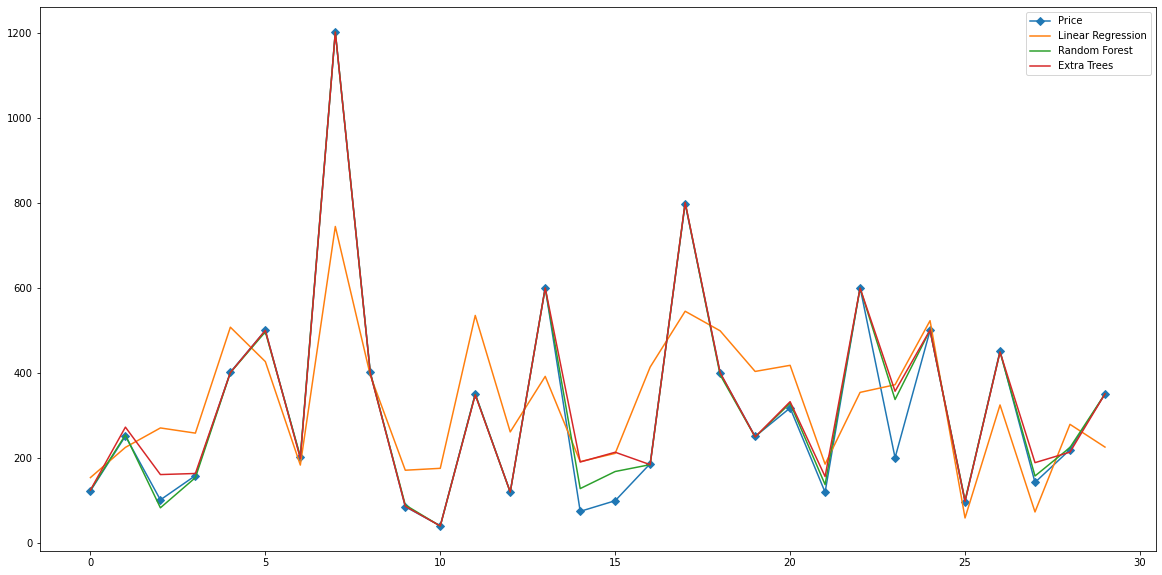

### Ajustes e Melhorias no Melhor Modelo

In [ ]:
#vizualizar a importancia de cada feature
features_importance = pd.DataFrame(modelo_et.feature_importances_, x_train.columns) #metodo feature_importances_
features_importance = features_importance.sort_values(by = 0, ascending = False)
plt.figure(figsize = (15, 5))
ax = sns.barplot(x = features_importance.index, y = features_importance[0])
ax.tick_params(axis = 'x', rotation = 90)

Ajustes finais

Retirando is business travel ready

Resultado Anterior

Modelo ExtraTrees: <br>
R2: 97.51% <br>
RSME: 41.56 <br>

In [ ]:
base_airbnb_encoded = base_airbnb_encoded.drop('is_business_travel_ready', axis=1)

y = base_airbnb_encoded['price']
x = base_airbnb_encoded.drop('price', axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Retirando bed type

In [ ]:
base_teste = base_airbnb_encoded.copy()
for i in base_teste:
  if 'bed_type' in i:
    base_teste = base_teste.drop(i, axis = 1)

y = base_teste['price']
x = base_teste.drop('price', axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

modelo_et.fit(x_train, y_train)
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

### Deploy

In [ ]:
x['price'] = y
x.to_csv('dados.csv')

In [ ]:
joblib.dump(modelo_et, 'modelo.joblib', compress = 3)